# Autoencoder and Denosier using Tensoflow

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras import layers, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import AdamW
from keras import Model
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

x_train_flat = x_train.reshape(-1, 784)
x_test_flat = x_test.reshape(-1, 784)

x_train_reshaped = x_train[..., np.newaxis]
x_test_reshaped = x_test[..., np.newaxis]

noise_factor = 0.2

x_train_noisy = x_train_reshaped + noise_factor * np.random.normal(0.0, 1.0, x_train_reshaped.shape)
x_test_noisy = x_test_reshaped + noise_factor * np.random.normal(0.0, 1.0, x_test_reshaped.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [64]:
def plot_graph(history, title):
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Validation Loss")
    plt.title("Loss")
    plt.legend()
    plt.tight_layout()
    plt.title(title)
    plt.show()

# Autoencoder Training Setup

In [65]:
model = Sequential([
    layers.Input((784,)),

    layers.Dense(512, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),

    layers.Dense(128, activation='swish', name="bottleneck_dense"),
    layers.BatchNormalization(),

    layers.Dense(256, activation='swish'),
    layers.BatchNormalization(),

    layers.Dense(512, activation='swish'),
    layers.BatchNormalization(),
    layers.Dropout(0.2),

    layers.Dense(784, activation='sigmoid'),
])


optimizer = AdamW(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy")

autoencoder_history = model.fit(
    x_train_flat,
    x_train_flat,
    epochs=15,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor="val_loss",
            min_delta=0.001,
            mode='min'
        ),
        ReduceLROnPlateau(
            patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss", verbose=1
        ),
    ],
)

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.4551 - val_loss: 0.2940 - learning_rate: 0.0010
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2957 - val_loss: 0.2832 - learning_rate: 0.0010
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2875 - val_loss: 0.2814 - learning_rate: 0.0010
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2836 - val_loss: 0.2762 - learning_rate: 0.0010
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2804 - val_loss: 0.2750 - learning_rate: 0.0010
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2792 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2775 - val_loss: 0.2720 - learning_rate: 0.0010
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2767 - val_loss: 0.2711 - learning_rate: 0.0010
Epoch 9/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2747 - val_loss: 0.2696 - learning_rate: 0.0010
Epoch 10

# Autoencoder Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


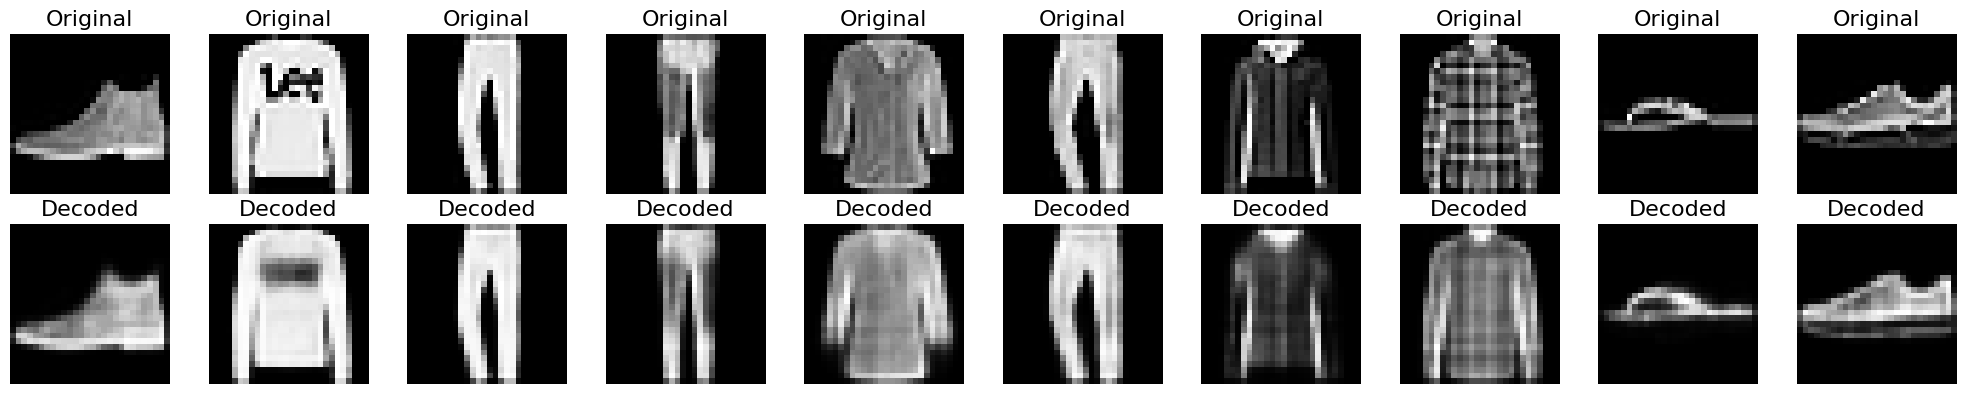

In [67]:
decoded_imgs = model.predict(x_test_flat)

n = 10
plt.figure(figsize=(20, 4))

for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title("Original", fontsize=16, loc='center')

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.axis("off")
    ax.set_title("Decoded", fontsize=16, loc='center')

plt.tight_layout()
plt.show()

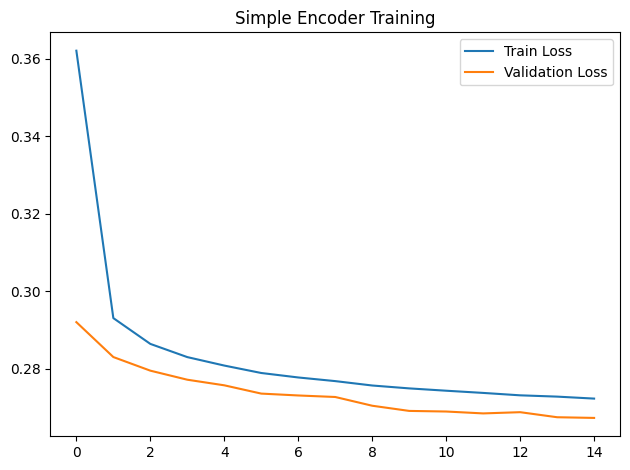

In [ ]:
plot_graph(autoencoder_history, "Simple Encoder Training")

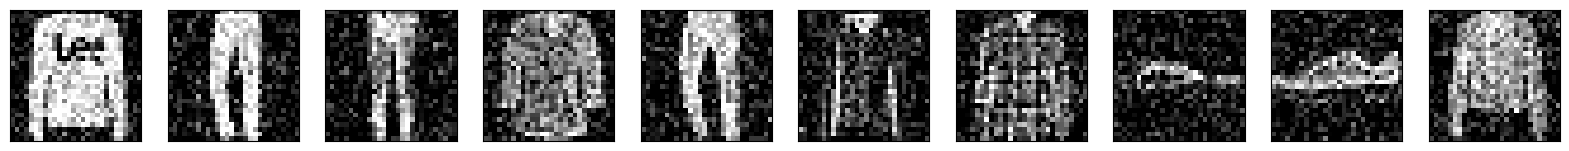

In [68]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(1, n + 1):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


# Denoiser Training Setup

In [69]:
denoise_model = Sequential(
    [
        layers.Input((28, 28, 1)),

        layers.Conv2D(32, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),
        layers.Dropout(0.1),

        layers.Conv2DTranspose(64, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2DTranspose(32, (3, 3), strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.BatchNormalization(),

        layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
    ]
)

optimizer = AdamW(learning_rate=0.001)
denoise_model.compile(optimizer=optimizer, loss="mean_squared_error", metrics=['mse'])


denoise_history = denoise_model.fit(
    x_train_noisy,
    x_train,
    epochs=30,
    batch_size=32,
    shuffle=True,
    validation_split=0.2,
    callbacks=[
        EarlyStopping(
            patience=10,
            restore_best_weights=True,
            monitor="val_loss",
            min_delta=0.001,
            mode='min'
        ),
        ReduceLROnPlateau(
            patience=3, factor=0.5, min_lr=1e-6, monitor="val_loss", verbose=1
        ),
    ],
)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0061 - val_mse: 0.0061 - learning_rate: 0.0010
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0070 - mse: 0.0070 - val_loss: 0.0062 - val_mse: 0.0062 - learning_rate: 0.0010
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0066 - mse: 0.0066 - val_loss: 0.0055 - val_mse: 0.0055 - learning_rate: 0.0010
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0054 - val_mse: 0.0054 - learning_rate: 0.0010
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0053 - val_mse: 0.0053 - learning_rate: 0.0010
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0052 - val_mse: 0.0052 - learning_rate: 0.0010
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0051 - val_mse: 0.0051 - learnin

# Denoiser Results

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


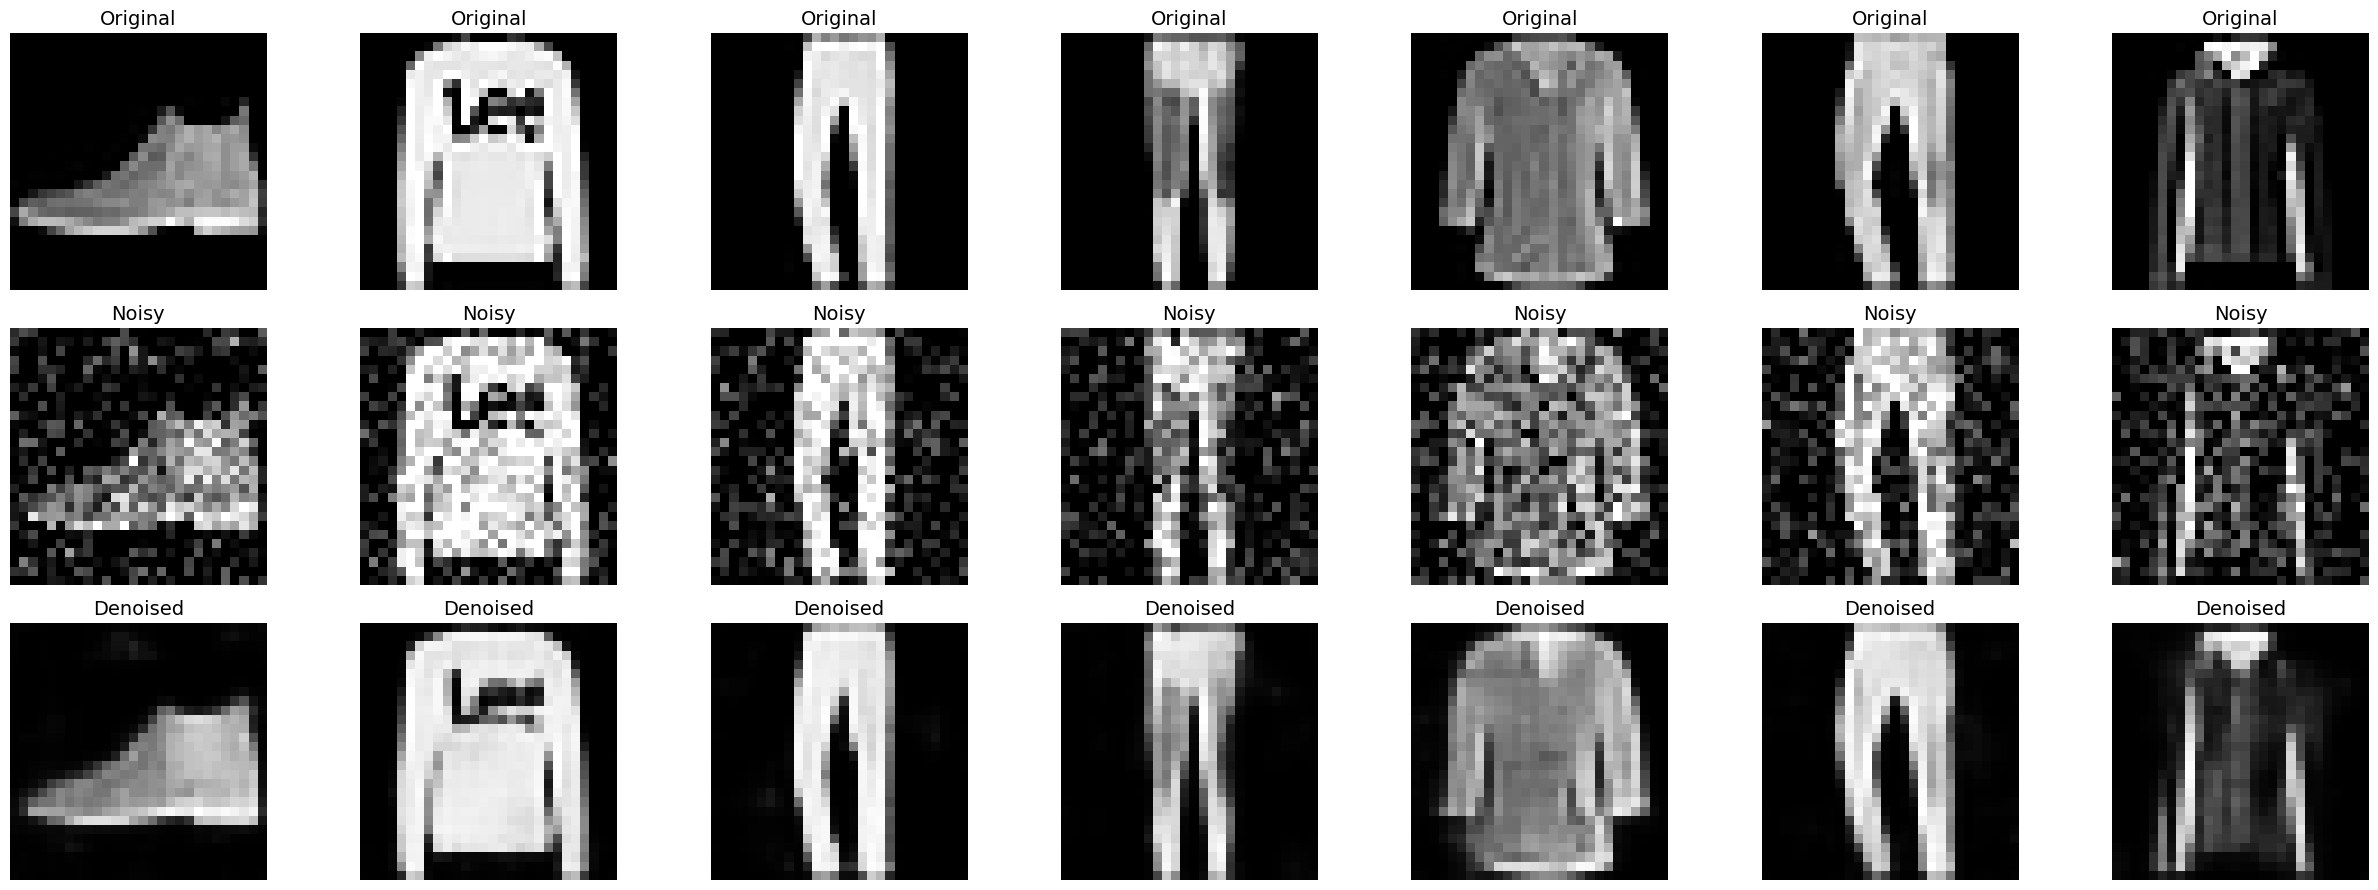

In [ ]:
decoded_imgs = denoise_model.predict(x_test_noisy)

n = 7
plt.figure(figsize=(25, 9)) 

for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    ax.imshow(tf.reshape(x_test[i], (28, 28)), cmap="gray")
    ax.set_title("Original", fontsize=14)
    ax.axis("off")

    ax = plt.subplot(3, n, i + 1 + n)
    ax.imshow(tf.reshape(x_test_noisy[i], (28, 28)), cmap="gray")
    ax.set_title("Noisy", fontsize=14)
    ax.axis("off")

    ax = plt.subplot(3, n, i + 1 + 2 * n)
    ax.imshow(decoded_imgs[i].reshape(28, 28), cmap="gray")
    ax.set_title("Denoised", fontsize=14)
    ax.axis("off")

plt.tight_layout()
plt.show()

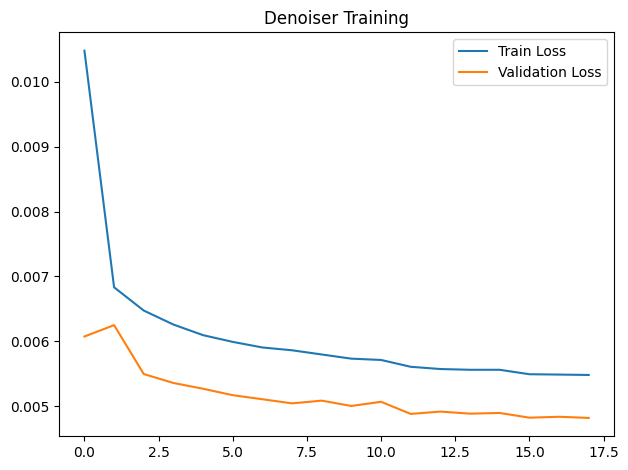

In [71]:
# Plot training history
plot_graph(denoise_history, "Denoiser Training")

In [74]:
model.summary()

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_53 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_51          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck_dense (Dense)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 784)            │       402,192 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,412,146 (13.02 MB)

 Trainable params: 1,136,272 (4.33 MB)

 Non-trainable params: 3,328 (13.00 KB)

 Optimizer params: 2,272,546 (8.67 MB)

In [ ]:
dense_encoder = Model(inputs=model.inputs, outputs=model.get_layer("bottleneck_dense").output)

# For conv model
conv_encoder = Model(
    inputs=denoise_model.inputs,
    outputs=denoise_model.layers[6].output
)


<Functional name=functional_20, built=True>

In [84]:
def visualize_bottleneck(encoder, x_data, y_labels, flatten_input=False, use_tsne=True, title="Latent Space"):
    if flatten_input:
        x_data = x_data.reshape((-1, 784))

    bottleneck_output = encoder.predict(x_data)

    if len(bottleneck_output.shape) > 2:
        bottleneck_output = bottleneck_output.reshape((bottleneck_output.shape[0], -1))

    if bottleneck_output.shape[1] > 2:
        if use_tsne:
            reduced = TSNE(n_components=2, perplexity=30, n_iter=300).fit_transform(bottleneck_output)
        else:
            reduced = PCA(n_components=2).fit_transform(bottleneck_output)
    else:
        reduced = bottleneck_output

    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=y_labels, cmap="tab10", s=10)
    plt.legend(*scatter.legend_elements(), title="Classes")
    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bottleneck Visualization

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/abhiram/projects/dl-rl-internship/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


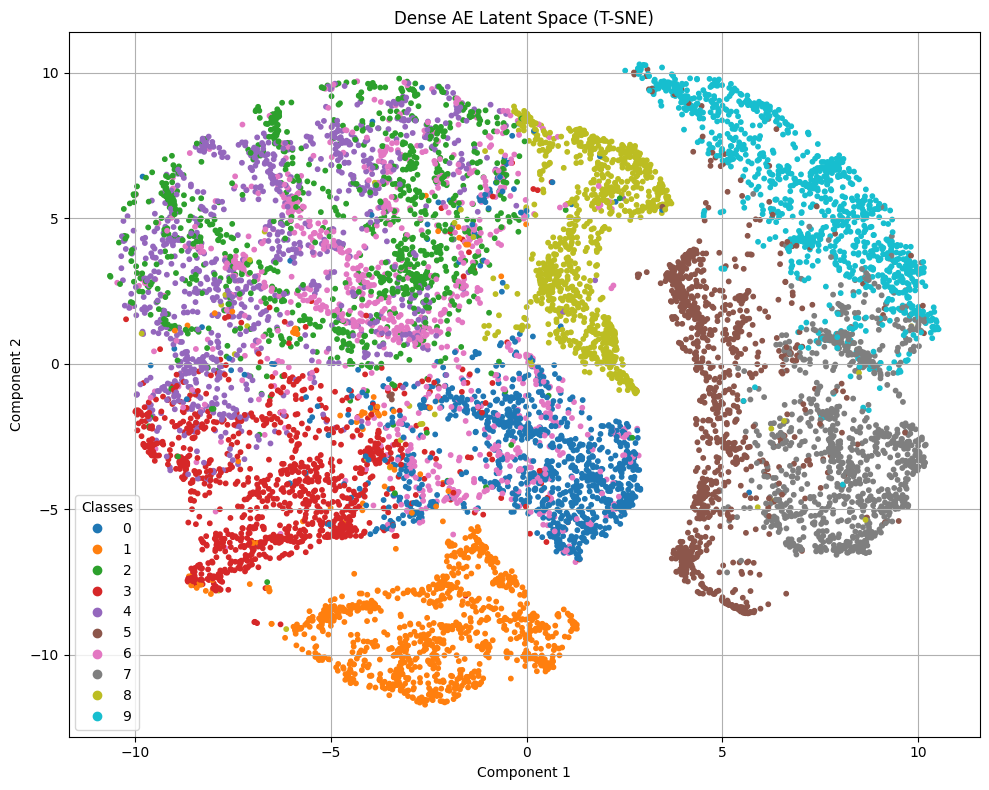

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/home/abhiram/projects/dl-rl-internship/.venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


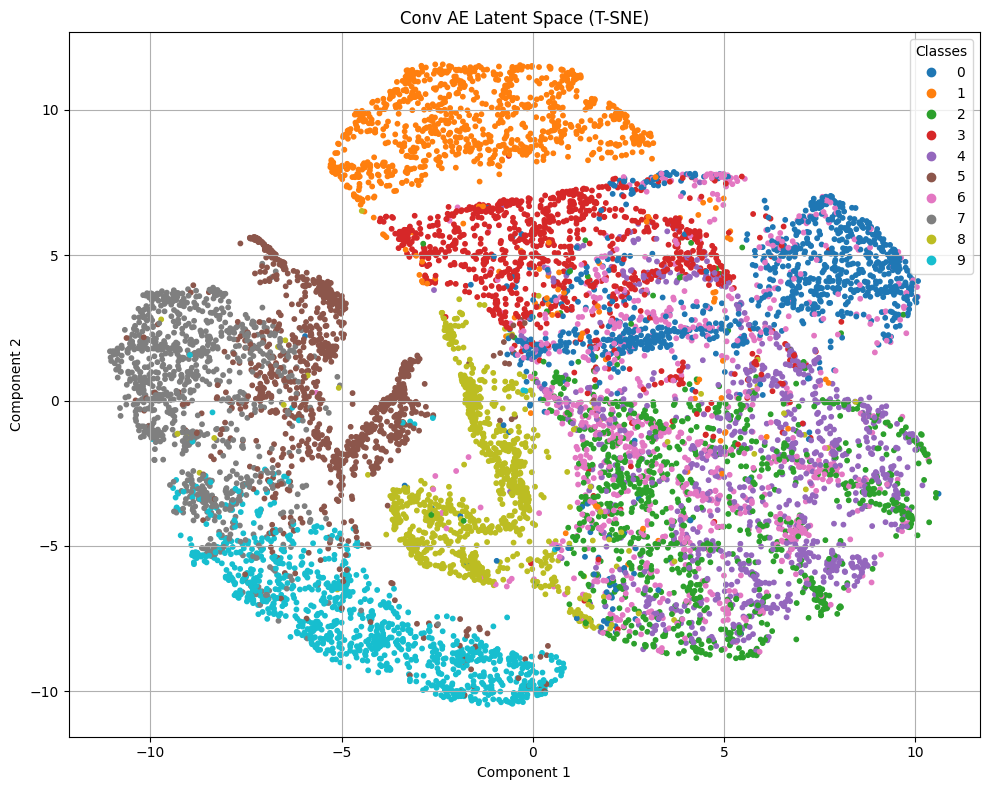

In [85]:
visualize_bottleneck(dense_encoder, x_test_flat, y_test, flatten_input=False, title="Dense AE Latent Space (T-SNE)")
visualize_bottleneck(conv_encoder, x_test_reshaped, y_test, flatten_input=False, title="Conv AE Latent Space (T-SNE)")

# Summary

### Model Architectures

#### 1. Dense Autoencoder (AE)

-   **Encoder**: `784 → 512 → 256 → 128` (bottleneck)

-   **Decoder**: `128 → 256 → 512 → 784`

-   Uses `Swish` activations, `BatchNorm`, and `Dropout`

#### 2. Convolutional Denoising Autoencoder

-   **Encoder**: Stacked `Conv2D` with `strides=2`, `LeakyReLU`, `BatchNorm`, and dropout

-   **Decoder**: `Conv2DTranspose` layers to upsample back to original shape

-   Final output layer uses `sigmoid` for pixel reconstruction

### Training Performance

#### Dense Autoencoder Training Curve

-   Steady loss drop on both train and validation sets

-   Shows good generalization, no major overfitting

-   Final validation loss stabilizes near 0.27

#### Conv Denoiser Training Curve

-   Fast convergence, low final loss (~0.005)

-   Better at pixel-level reconstructions due to spatial ops

-   Lower training loss than Dense AE

### Latent Space Visualization (T-SNE)

#### Dense AE Latent Space

-   **Some clusters are distinct** (e.g., classes `0`, `1`, `5`, `9`), showing that the AE has learned to encode different digit classes differently.

    -   However, many class boundaries are fuzzy or overlapping (notably `2`, `3`, `4`, `5`, `6`), indicating:
    -   The latent representation isn't strongly discriminative.
    -   The model likely focuses on general reconstruction, not class-specific features.
    - The Dense AE captures some structure but does not fully disentangle the classes in its bottleneck.

#### Conv AE Latent Space

-   Tighter, well-separated clusters for most classes, especially `1`, `0`, `9`, `6`, `5`.

    -   Less overlap than Dense AE, showing:

    -   Stronger feature extraction from the input images.

    -   The model's use of spatial hierarchies (via convolution) helps encode meaningful structure.

        -   Some overlap still exists (e.g., `3`, `4`, `7`), but it's significantly reduced.

    - Conv AE learns a more structured latent space.

    - The model creates disentangled representations, even without labels, due to its deeper architecture.